# Pinch Off Measurement with DC and AC

## Imports

In [1]:
# Copy this to all notebooks!
from qcodes.logger import start_all_logging
start_all_logging()

# Import qcodes and other necessary packages
import qcodes as qc
import numpy as np
import time

# Import device drivers 
from qcodes.instrument_drivers.QuantumDesign.DynaCoolPPMS import DynaCool
from qcodes.instrument_drivers.Keysight.Infiniium import Infiniium


from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.database import initialise_database
from qcodes.dataset.experiment_container import (Experiment,
                                                 load_last_experiment,
                                                 new_experiment)
from qcodes.dataset.experiment_container import load_experiment_by_name
from qcodes.instrument.base import Instrument
from qcodes import Station

import matplotlib.pyplot as plt
import matplotlib
from time import sleep
from qcodes.dataset.data_export import flatten_1D_data_for_plot

from qcodes.utils.dataset.doNd import do1d,do2d


Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\lyn-ppmsmsr-01usr\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\lyn-ppmsmsr-01usr\.qcodes\logs\200514-16320-qcodes.log
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\lyn-ppmsmsr-01usr\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


2020-05-14 11:19:33,028 ¦ py.warnings ¦ WARNING ¦ warnings ¦ _showwarnmsg ¦ 110 ¦ C:\Users\lyn-ppmsmsr-01usr\miniconda3\envs\qcodes\lib\site-packages\qcodes\dataset\database.py:13: UserWarning: The module `qcodes.dataset.database` is deprecated.
Public features are available at the import of `qcodes`.
Private features are available in `qcodes.dataset.sqlite.*` modules.
  warnings.warn('The module `qcodes.dataset.database` is deprecated.\n'



Qcodes Logfile : C:\Users\lyn-ppmsmsr-01usr\.qcodes\logs\200514-16320-qcodes.log


## Station
(Need to load 3 Keithleys and 6 Lock-In Amps)

In [2]:
# Create station, instantiate instruments
Instrument.close_all()
path_to_station_file = 'C:/Users/lyn-ppmsmsr-01usr/Desktop/station.yaml'
#                       'file//station.yaml'
# Here we load the station file.
station = Station()
station.load_config_file(path_to_station_file)

# Connect to ppms
#Instrument.find_instrument('ppms_cryostat')
ppms = DynaCool.DynaCool(name = "ppms_cryostat", address="TCPIP0::10.10.117.37::5000::SOCKET")
station.add_component(ppms)

# SRS
lockin_1 = station.load_instrument('lockin_1')
lockin_2 = station.load_instrument('lockin_2')
lockin_3 = station.load_instrument('lockin_3')
lockin_4 = station.load_instrument('lockin_4')
lockin_5 = station.load_instrument('lockin_5')
lockin_6 = station.load_instrument('lockin_6')

# DMMs
dmm_a = station.load_instrument('Keithley_A')
dmm_b = station.load_instrument('Keithley_B')
dmm_c = station.load_instrument('Keithley_C')

dmm_a.smua.volt(0) # Set voltages to 0
dmm_a.smub.volt(0) # Set voltages to 0

dmm_b.smua.volt(0) # Set voltages to 0
dmm_b.smub.volt(0) # Set voltages to 0

dmm_c.smua.volt(0) # Set voltages to 0
dmm_c.smub.volt(0) # Set voltages to 0

Connected to:  QuantumDesign dynacool (serial:N/A, firmware:N/A) in 0.40s
Connected to: Stanford_Research_Systems SR830 (serial:s/n91493, firmware:ver1.07) in 0.11s
Connected to: Stanford_Research_Systems SR830 (serial:s/n91797, firmware:ver1.07) in 0.04s
Connected to: Stanford_Research_Systems SR830 (serial:s/n87831, firmware:ver1.07) in 0.03s
Connected to: Stanford_Research_Systems SR830 (serial:s/n57026, firmware:ver1.07) in 0.03s
Connected to: Stanford_Research_Systems SR830 (serial:s/n91992, firmware:ver1.07) in 0.04s
Connected to: Stanford_Research_Systems SR830 (serial:s/n91973, firmware:ver1.07) in 0.04s
Connected to: Keithley Instruments Inc. 2614B (serial:4376445, firmware:3.2.2) in 0.02s
Connected to: Keithley Instruments Inc. 2612B (serial:4428183, firmware:3.3.5) in 0.02s
Connected to: Keithley Instruments Inc. 2614B (serial:4376447, firmware:3.2.2) in 0.02s


In [3]:
for inst in station.components.values():
    inst.print_readable_snapshot()

ppms_cryostat:
	parameter           value
--------------------------------------------------------------------------------
IDN                  :	{'vendor': ' QuantumDesign', 'model': 'dynacool', 'ser...
chamber_state        :	high vacuum 
chamber_temperature  :	300 (K)
field_approach       :	linear 
field_measured       :	-1.1108e-05 (T)
field_ramp           :	None (T)
field_rate           :	0 (T/s)
field_target         :	-1.1108e-05 (T)
field_tolerance      :	0.0005 (T)
magnet_state         :	holding 
temperature          :	300 (K)
temperature_rate     :	0 (K/s)
temperature_setpoint :	300 (K)
temperature_settling :	fast settle 
temperature_state    :	stable 
timeout              :	5 (s)
lockin_1:
	parameter       value
--------------------------------------------------------------------------------
IDN              :	{'vendor': 'Stanford_Research_Systems', 'model': 'SR830', ...
P                :	0 (deg)
R                :	0 (V)
R_offset         :	(0.0, 0) 
X                :	0 (V)
X

## DB File, Location and Functions

In [4]:
#config.save_to_home  ### Initialize database, make new measurement
%matplotlib notebook

from qcodes.dataset.database import get_DB_location
from qcodes import config
import os.path
import os

mainpath = 'C:/Users/MicrosoftQ/Desktop/Results'
config.current_config.core.db_location = os.path.join(mainpath,'MMSTEST_200504.db')
config.current_config
newpath = os.path.join(mainpath,'MMSTEST_200504') 
if not os.path.exists(newpath):
    os.makedirs(newpath)
figurepath = newpath
initialise_database()


# DIFFERENTIAL CONDUCTANCE FOR A TWO PROBE MEASUREMENT

ac_divider     = 1e-4
gain_curr_ampl = 1e6

def desoverh():
    volt_ampl_1 = lockin_1.amplitude
    amplitude_curr_1 = lockin_1.R
    dcond_1 = (amplitude_curr_1()/gain_curr_ampl)/(volt_ampl_1()*ac_divider)/go
    return dcond_1     
    
try:
    lockin_1.add_parameter("diff_conductance_1", label="dI/dV", unit="2e^2/h", get_cmd = desoverh)
except KeyError:
    print("parameter already exists. Deleting. Try again")
    del lockin_1.parameters['diff_conductance_1']

    
def desoverh():
    volt_ampl_3 = lockin_3.amplitude
    amplitude_curr_3 = lockin_3.R
    dcond_3 = (amplitude_curr_3()/gain_curr_ampl)/(volt_ampl_3()*ac_divider)/go
    return dcond_3    
    
try:
    lockin_3.add_parameter("diff_conductance_2", label="dI/dV", unit="2e^2/h", get_cmd = desoverh)
except KeyError:
    print("parameter already exists. Deleting. Try again")
    del lockin_3.parameters['diff_conductance_2']

    
def desoverh():
    volt_ampl_5 = lockin_5.amplitude
    amplitude_curr_5 = lockin_5.R
    dcond_5 = (amplitude_curr_5()/gain_curr_ampl)/(volt_ampl_5()*ac_divider)/go
    return dcond_5     
    
try:
    lockin_5.add_parameter("diff_conductance_3", label="dI/dV", unit="2e^2/h", get_cmd = desoverh)
except KeyError:
    print("parameter already exists. Deleting. Try again")
    del lockin_5.parameters['diff_conductance_3']

#------------------------------------------------------------------------
def wait_for_field():
    time.sleep(0.1)
    Magnet_state = ppms.magnet_state()
    while Magnet_state is not 'holding':
        #print('waiting for field')
        time.sleep(0.1)
        Magnet_state = ppms.magnet_state()
        #print('field ready')
    return

def wait_for_field_ramp():
    Magnet_state = ppms.magnet_state()
    while Magnet_state is not 'ramping':
        time.sleep(0.1)
        Magnet_state = ppms.magnet_state()
    return

def field_ready():
    return ppms.magnet_state() == 'holding'

def wait_for_temp():
    Temp_state = ppms.temperature_state()
    while Temp_state is not 'stable':
        time.sleep(1)
        Temp_state = ppms.temperature_state()
    return


#--------------------------------------------------------------------------
#fig, ax = plt.subplots(1)
#fig2, ax2 = plt.subplots(1)

## 1D & 2D Plot for Hall Measurement
(All 6 Lock-In Amps data should be saved in 1 measurement scan)

Starting experimental run with id: 7. 


<IPython.core.display.Javascript object>


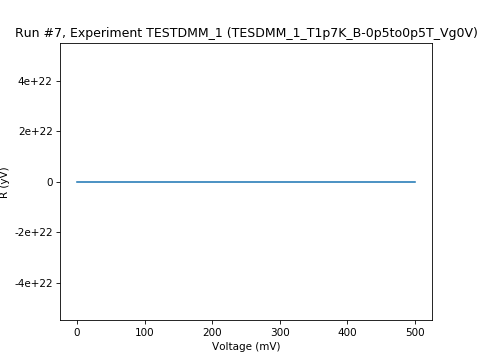

<IPython.core.display.Javascript object>


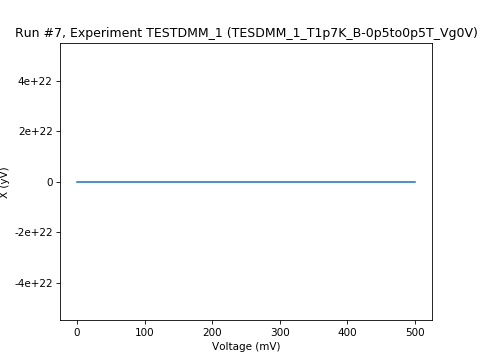

<IPython.core.display.Javascript object>


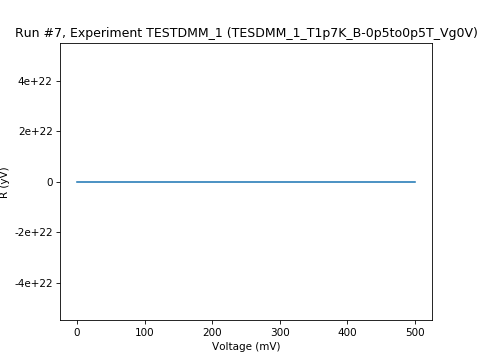

<IPython.core.display.Javascript object>


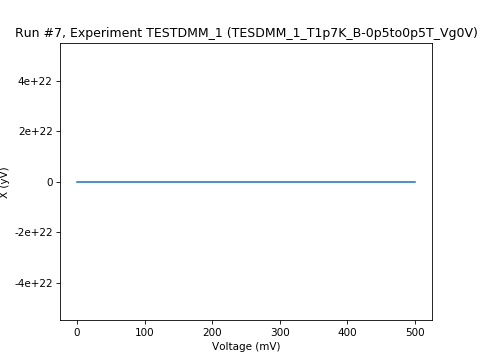

<IPython.core.display.Javascript object>


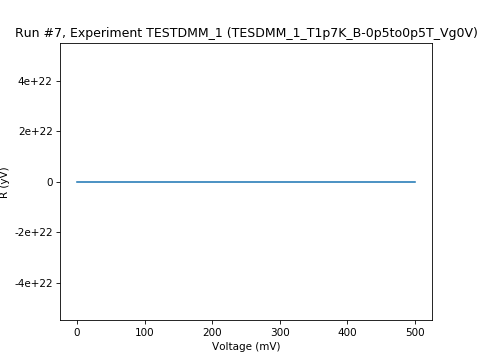

<IPython.core.display.Javascript object>


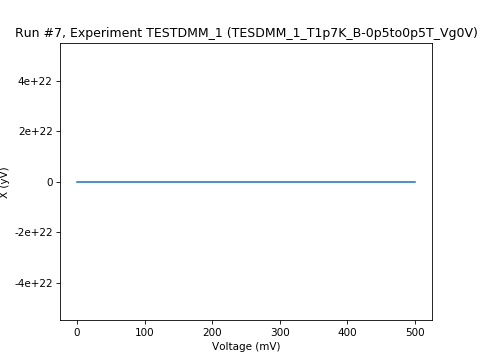

(results #7@C:\Users\MicrosoftQ\Desktop\Results\MMSTEST_200504.db
 ----------------------------------------------------------------
 Keithley_A_smub_volt - numeric
 lockin_1_R - numeric
 lockin_2_X - numeric
 lockin_3_R - numeric
 lockin_4_X - numeric
 lockin_5_R - numeric
 lockin_6_X - numeric,
 [None, None, None, None, None, None])

In [5]:
dmm_a.smub.output('on')
dmm_b.smub.output('on')
dmm_c.smub.output('on')

gate = dmm_a.smub.volt
gate_1 = dmm_b.smub.volt
gate_2 = dmm_c.smub.volt


magnetic_field = ppms.field_ramp
ppms.field_rate(0.22)

temperature = ppms.temperature_setpoint
ppms.temperature_rate(0.3)
new_experiment(name='TESTDMM_1', sample_name='TESDMM_1_T1p7K_B-0p5to0p5T_Vg0V')

#Scan with Magnetic Field
#gate()
#do1d(magnetic_field, -0.5, 0.5, 11, 1, lockin_1.R, lockin_2.X, lockin_3.R, lockin_4.X, lockin_5.R, lockin_6.X)

    # Scan with Gate voltage
#magnetic_field(0)
#temperature(1.7)
do1d(gate, 0, 0.5, 11, 1, lockin_1.R, lockin_2.X, lockin_3.R, lockin_4.X, lockin_5.R, lockin_6.X)

    # Scan with Temperature
#magnetic_field(0)
#gate(1.5)
#do1d(temperature, 1.7, 301.7, 301, 1, lockin_1.R, lockin_2.X, lockin_3.R, lockin_4.X, lockin_5.R, lockin_6.X)

    # 2D scan with Gate voltage and Magnetic Field
#do2d(gate, 0, 5, 21, 1,
#     magnetic_field, -2.5, 2.5, 101, 1,
#         lockin_1.R, lockin_2.X, lockin_3.R, lockin_4.X, lockin_5.R, lockin_6.X)

    # 2D scan with Temperature and Magnetic Field
#do2d(temperature, 1.7, 301.7, 61, 1,
#     magnetic_field, -1.5, 1.5, 61, 1,
#         lockin_1.R, lockin_2.X, lockin_3.R, lockin_4.X, lockin_5.R, lockin_6.X)


In [28]:
dmm_a.smub.output('on')
dmm_b.smub.output('on')
dmm_c.smub.output('on')
gate(0)

ppms.field_target(0)
ppms.field_rate(0.22)
ppms.ramp('non-blocking')

#ppms.temperature_setpoint(1.7)

In [68]:
10e-3/3.13e3

3.1948881789137383e-06

<IPython.core.display.Javascript object>


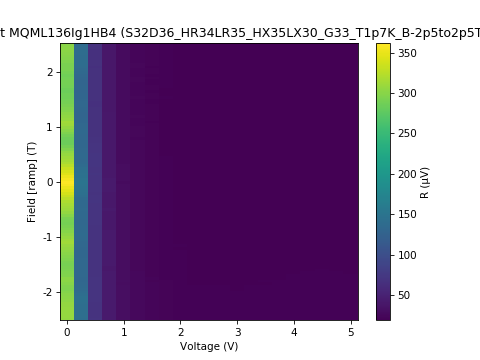

<IPython.core.display.Javascript object>


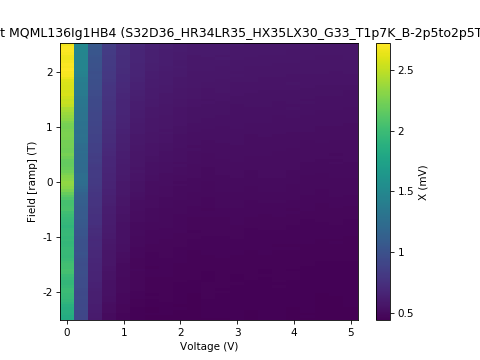

([<matplotlib.axes._subplots.AxesSubplot at 0x237f5098f08>,
  <matplotlib.colorbar.Colorbar at 0x237ec99f448>])

In [50]:
plot_by_id(6)

## Pinch-off curves DC using Keithley only

Normal sweep without live plotting. Results are shown when each sweep is finished.
(All 3 Keithleys should work coincidently)

Starting experimental run with id: 19. 
done sweeping up


<IPython.core.display.Javascript object>


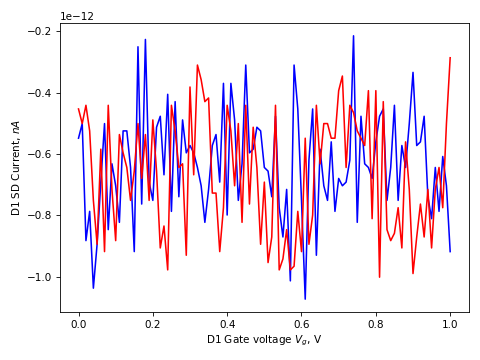

<IPython.core.display.Javascript object>


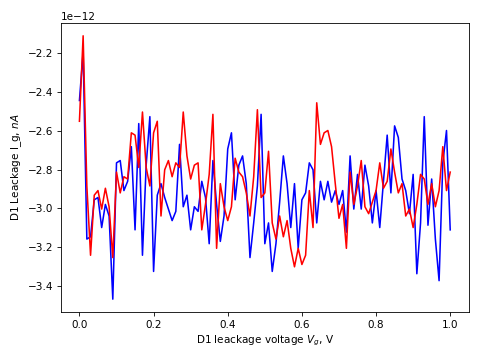

<IPython.core.display.Javascript object>


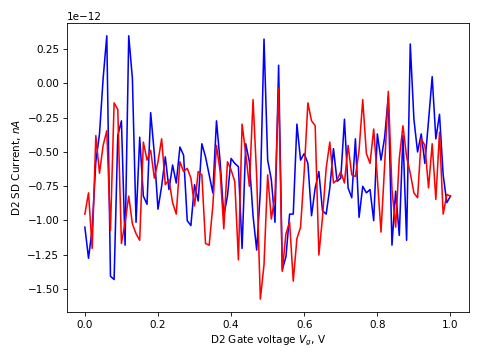

<IPython.core.display.Javascript object>


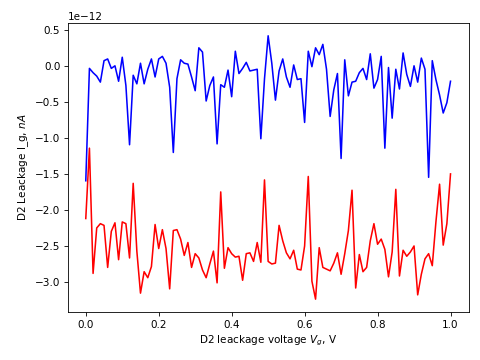

<IPython.core.display.Javascript object>


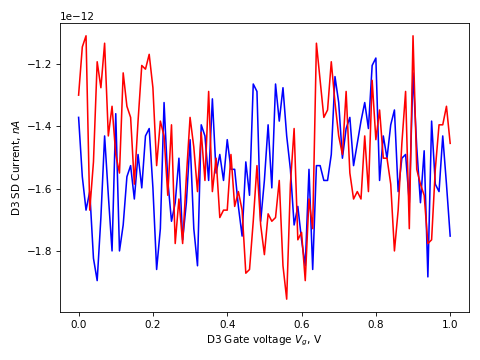

<IPython.core.display.Javascript object>


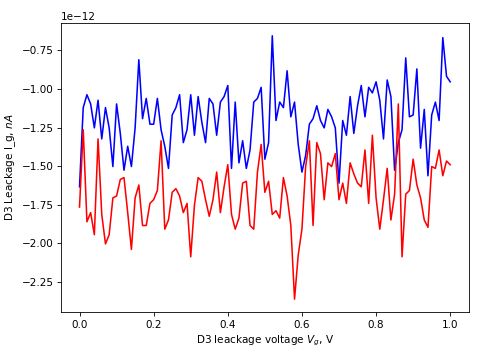

Starting experimental run with id: 20. 
done sweeping down


In [56]:
# All DMMs swith on
dmm_a.smua.output('on')
dmm_a.smub.output('on')

dmm_b.smua.output('on')
dmm_b.smub.output('on')

dmm_c.smua.output('on')
dmm_c.smub.output('on')

# define new names for Keithley channels
bias_a = dmm_a.smua.volt
gate_a = dmm_a.smub.volt
current_a = dmm_a.smua.curr
leakage_a = dmm_a.smub.curr

bias_b = dmm_b.smua.volt
gate_b = dmm_b.smub.volt
current_b = dmm_b.smua.curr
leakage_b = dmm_b.smub.curr

bias_c = dmm_c.smua.volt
gate_c = dmm_c.smub.volt
current_c = dmm_c.smua.curr
leakage_c = dmm_c.smub.curr

# to give the parameter numbers
# DMM A
bias_a (0.1) #SD Vias V
gate_a_start = 0 #V
gate_a_end = 1 #V
Npoints = 101

# DMM B
bias_b (0.1) #SD Vias V
gate_b_start = 0 #V
gate_b_end = 1 #V
Npoints = 101

# DMM C
bias_c (0.1) #SD Vias V
gate_c_start = 0 #V
gate_c_end = 1 #V
Npoints = 101

temperature = 1.7 #K
magnetic_field = 0 #T


timedelay = 0.1 #
Experiment_name = 'TESDMM_3_T1p7K_B-0T_Vg0to1V'
Sample_name = "TESTDMMs"

meas = Measurement()
meas.write_period = timedelay

#----------------------------------------------------------------------------------------------------------
meas.register_parameter(gate_a)  # register independent parameter
meas.register_parameter(current_a, setpoints=(gate_a,))  # now register the dependent one
meas.register_parameter(leakage_a, setpoints=(gate_a,))     # now register the dependent one
#meas.register_parameter(bias_a, setpoints=(gate_a,))   # now register the dependent one

meas.register_parameter(gate_b)  # register independent parameter
meas.register_parameter(current_b, setpoints=(gate_b,))  # now register the dependent one
meas.register_parameter(leakage_b, setpoints=(gate_b,))     # now register the dependent one
#meas.register_parameter(bias_b, setpoints=(gate_b,))   # now register the dependent one

meas.register_parameter(gate_c)  # register independent parameter
meas.register_parameter(current_c, setpoints=(gate_c,))  # now register the dependent one
meas.register_parameter(leakage_c, setpoints=(gate_c,))     # now register the dependent one
#meas.register_parameter(bias_c, setpoints=(gate_c,))   # now register the dependent one

meas.add_before_run(lambda: ppms.field_target(magnetic_field), ())  # set magnetic field
meas.add_before_run(lambda: ppms.ramp(mode='blocking'), ())  # set magnetic field
meas.add_before_run(lambda: ppms.temperature_setpoint(temperature), ())  # set temperature
#meas.add_before_run(lambda: wait_for_field(), ())  # wait for magnetic field to stabilize
#meas.add_before_run(lambda: wait_for_temp(), ())  # wait for temperature to stabilize
meas.add_before_run(lambda: time.sleep(1), ())  # delay 1s

meas.add_before_run(lambda: dmm_a.smua.output('on'), ())  # Turn Keithley output A on
meas.add_before_run(lambda: dmm_a.smub.output('on'), ())  # Turn Keithley output B on

meas.add_before_run(lambda: dmm_b.smua.output('on'), ())  # Turn Keithley output A on
meas.add_before_run(lambda: dmm_b.smub.output('on'), ())  # Turn Keithley output B on

meas.add_before_run(lambda: dmm_c.smua.output('on'), ())  # Turn Keithley output A on
meas.add_before_run(lambda: dmm_c.smub.output('on'), ())  # Turn Keithley output B on

#meas.add_before_run(lambda: bias_a(bias_setpoint), ())  # set bias to defined value
#meas.add_before_run(lambda: bias_b(bias_setpoint), ())  # set bias to defined value
#meas.add_before_run(lambda: bias_c(bias_setpoint), ())  # set bias to defined value
#meas.add_before_run(lambda: time.sleep(1), ())  # delay 1s

#meas.add_after_run(lambda: bias_a(0), ())  # Set bias to 0
#meas.add_after_run(lambda: bias_b(0), ())  # Set bias to 0
#meas.add_after_run(lambda: bias_c(0), ())  # Set bias to 0

meas.add_after_run(lambda: dmm_a.smua.output('off'), ())  # Turn Keithley output A off
meas.add_after_run(lambda: dmm_a.smub.output('off'), ())  # Turn Keithley output B off

meas.add_after_run(lambda: dmm_b.smua.output('off'), ())  # Turn Keithley output A off
meas.add_after_run(lambda: dmm_b.smub.output('off'), ())  # Turn Keithley output B off

meas.add_after_run(lambda: dmm_c.smua.output('off'), ())  # Turn Keithley output A off
meas.add_after_run(lambda: dmm_c.smub.output('off'), ())  # Turn Keithley output B off


# Sweep up gate without plotting
# This measurement just saves the gate voltage array set (not the actual value),
# the measured current and the gate leakage
new_experiment(name=Experiment_name+' up', sample_name = Sample_name)
with meas.run() as datasaver:
    for gate_setpoint in np.linspace(gate_start, gate_end, Npoints):
        
        gate_a(gate_setpoint)
        gate_b(gate_setpoint)
        gate_c(gate_setpoint)
        
        V_g_a = gate_a()
        I_sd_a = current_a()
        I_g_a = leakage_a()
        #V_sd_a = bias_a()
        
        V_g_b = gate_b()
        I_sd_b = current_b()
        I_g_b = leakage_b()
        #V_sd_b = bias_b()
        
        V_g_c = gate_c()
        I_sd_c = current_c()
        I_g_c = leakage_c()
        #V_sd_c = bias_c()
        
        datasaver.add_result((gate_a, V_g_a), (current_a, I_sd_a), (leakage_a, I_g_a),
                             (gate_b, V_g_b), (current_b, I_sd_b), (leakage_b, I_g_b),
                             (gate_c, V_g_c), (current_c, I_sd_c), (leakage_c, I_g_c))
        
        time.sleep(timedelay)    #sleep
    dataid_up = datasaver.run_id  # convenient to have for plotting
    
print("done sweeping up")
# Plotting the measured data for sweeping up
# PLOT 1: I-V
# PLOT 2: L-V           
dataset = qc.load_by_id(dataid_up)
#labels = dataset.parameters.split(",")

mydata = dataset.get_parameter_data()
#print(mydata.keys())
#print(mydata['Keithley_A_smub_curr'])

# DMM A
v_a = mydata['Keithley_A_smub_curr']['Keithley_A_smub_volt']
c_a = mydata['Keithley_A_smua_curr']['Keithley_A_smua_curr']
l_v_a = mydata['Keithley_A_smub_curr']['Keithley_A_smub_volt']
l_c_a = mydata['Keithley_A_smub_curr']['Keithley_A_smub_curr']

# DMM B
v_b = mydata['Keithley_B_smub_curr']['Keithley_B_smub_volt']
c_b = mydata['Keithley_B_smua_curr']['Keithley_B_smua_curr']
l_v_b = mydata['Keithley_B_smub_curr']['Keithley_B_smub_volt']
l_c_b = mydata['Keithley_B_smub_curr']['Keithley_B_smub_curr']

# DMM C
v_c = mydata['Keithley_C_smub_curr']['Keithley_C_smub_volt']
c_c = mydata['Keithley_C_smua_curr']['Keithley_C_smua_curr']
l_v_c = mydata['Keithley_C_smub_curr']['Keithley_C_smub_volt']
l_c_c = mydata['Keithley_C_smub_curr']['Keithley_C_smub_curr']


# Figures for DMM A

fig1,ax1 = plt.subplots(1,1)
ax1.set_xlabel(r'D1 Gate voltage $V_g$, V')
ax1.set_ylabel(r'D1 SD Current, $nA$')
ax1.plot(v_a,c_a,'b-')
fig1.canvas.draw()
fig1.tight_layout()

fig2,ax2 = plt.subplots(1,1)
ax2.set_xlabel(r'D1 leackage voltage $V_g$, V')
ax2.set_ylabel(r'D1 Leackage I_g, $nA$')
ax2.plot(l_v_a,l_c_a,'b-')  
fig2.canvas.draw()
fig2.tight_layout()

# Figures for DMM B

fig3,ax3 = plt.subplots(1,1)
ax3.set_xlabel(r'D2 Gate voltage $V_g$, V')
ax3.set_ylabel(r'D2 SD Current, $nA$')
ax3.plot(v_b,c_b,'b-')
fig3.canvas.draw()
fig3.tight_layout()

fig4,ax4 = plt.subplots(1,1)
ax4.set_xlabel(r'D2 leackage voltage $V_g$, V')
ax4.set_ylabel(r'D2 Leackage I_g, $nA$')
ax4.plot(l_v_b,l_c_b,'b-')  
fig4.canvas.draw()
fig4.tight_layout()

# Figures for DMM C

fig5,ax5 = plt.subplots(1,1)
ax5.set_xlabel(r'D3 Gate voltage $V_g$, V')
ax5.set_ylabel(r'D3 SD Current, $nA$')
ax5.plot(v_c,c_c,'b-')
fig5.canvas.draw()
fig5.tight_layout()

fig6,ax6 = plt.subplots(1,1)
ax6.set_xlabel(r'D3 leackage voltage $V_g$, V')
ax6.set_ylabel(r'D3 Leackage I_g, $nA$')
ax6.plot(l_v_c,l_c_c,'b-')  
fig6.canvas.draw()
fig6.tight_layout()

# Sweep down gate without plotting
# This measurement just saves the gate voltage array set (not the actual value),
# the measured current and the gate leakage
new_experiment(name=Experiment_name+' down', sample_name = Sample_name)
with meas.run() as datasaver:
    for gate_setpoint in np.linspace(gate_end, gate_start, Npoints):
        
        gate_a(gate_setpoint)
        gate_b(gate_setpoint)
        gate_c(gate_setpoint)
        
        V_g_a = gate_a()
        I_sd_a = current_a()
        I_g_a = leakage_a()
        #V_sd_a = bias_a()
        
        V_g_b = gate_b()
        I_sd_b = current_b()
        I_g_b = leakage_b()
        #V_sd_b = bias_b()
        
        V_g_c = gate_c()
        I_sd_c = current_c()
        I_g_c = leakage_c()
        #V_sd_c = bias_c()
        
        datasaver.add_result((gate_a, V_g_a), (current_a, I_sd_a), (leakage_a, I_g_a),
                             (gate_b, V_g_b), (current_b, I_sd_b), (leakage_b, I_g_b),
                             (gate_c, V_g_c), (current_c, I_sd_c), (leakage_c, I_g_c))
        
        time.sleep(timedelay)    #sleep
    dataid_down = datasaver.run_id  # convenient to have for plotting 
print("done sweeping down")
# Plotting the measured data for sweeping down
# PLOT 1: I-V
# PLOT 2: L-V           
dataset = qc.load_by_id(dataid_down)
#labels = dataset.parameters.split(",")


mydata = dataset.get_parameter_data()

# DMM A
v_a = mydata['Keithley_A_smub_curr']['Keithley_A_smub_volt']
c_a = mydata['Keithley_A_smua_curr']['Keithley_A_smua_curr']
l_v_a = mydata['Keithley_A_smub_curr']['Keithley_A_smub_volt']
l_c_a = mydata['Keithley_A_smub_curr']['Keithley_A_smub_curr']

# DMM B
v_b = mydata['Keithley_B_smub_curr']['Keithley_B_smub_volt']
c_b = mydata['Keithley_B_smua_curr']['Keithley_B_smua_curr']
l_v_b = mydata['Keithley_B_smub_curr']['Keithley_B_smub_volt']
l_c_b = mydata['Keithley_B_smub_curr']['Keithley_B_smub_curr']

# DMM C
v_c = mydata['Keithley_C_smub_curr']['Keithley_C_smub_volt']
c_c = mydata['Keithley_C_smua_curr']['Keithley_C_smua_curr']
l_v_c = mydata['Keithley_C_smub_curr']['Keithley_C_smub_volt']
l_c_c = mydata['Keithley_C_smub_curr']['Keithley_C_smub_curr']


# v = flatten_1D_data_for_plot(dataset.get_data(labels[0])) #V
# c = flatten_1D_data_for_plot(dataset.get_data(labels[1]))*1e9 # nA 
# l = flatten_1D_data_for_plot(dataset.get_data(labels[2]))*1e9 # nA

# Figures for DMM A

ax1.plot(v_a,c_a,'r-')
fig1.canvas.draw()

ax2.plot(l_v_a,l_c_a,'r-')  
fig2.canvas.draw()
 
plt.figure(fig1.number)          
plt.savefig(newpath + str(dataid_up)+' '+str(dataid_down)+' '+Sample_name+' '+Experiment_name+'.png')
plt.savefig(newpath + str(dataid_up)+' '+str(dataid_down)+' '+Sample_name+' '+Experiment_name+'.svg')

# Figures for DMM B

ax3.plot(v_b,c_b,'r-')
fig2.canvas.draw()

ax4.plot(l_v_b,l_c_b,'r-')  
fig2.canvas.draw()
 
plt.figure(fig2.number)          
plt.savefig(newpath + str(dataid_up)+' '+str(dataid_down)+' '+Sample_name+' '+Experiment_name+'.png')
plt.savefig(newpath + str(dataid_up)+' '+str(dataid_down)+' '+Sample_name+' '+Experiment_name+'.svg')

# Figures for DMM A

ax5.plot(v_c,c_c,'r-')
fig3.canvas.draw()

ax6.plot(l_v_c,l_c_c,'r-')  
fig3.canvas.draw()
 
plt.figure(fig3.number)          
plt.savefig(newpath + str(dataid_up)+' '+str(dataid_down)+' '+Sample_name+' '+Experiment_name+'.png')
plt.savefig(newpath + str(dataid_up)+' '+str(dataid_down)+' '+Sample_name+' '+Experiment_name+'.svg')


In [57]:
# After run setup
#keith.smua.output('on')
dmm_a.smua.output('off')
dmm_a.smua.volt(0)
dmm_a.smub.output('off')
dmm_a.smub.volt(0)
dmm_b.smua.output('off')
dmm_b.smua.volt(0)
dmm_b.smub.output('off')
dmm_b.smub.volt(0)
dmm_c.smua.output('off')
dmm_c.smua.volt(0)
dmm_c.smub.output('off')
dmm_c.smub.volt(0)
#ppms.field_target(0)
#temperature(1.7)

# Frequency test

In [60]:
# we create a dummy variable to control the number of times that we will repeat the measurement

def number(n):
    return n
    
try:
    dmm_a.smua.add_parameter("counts", label="N", unit="times",
                               get_cmd=number)
except KeyError:
    print("parameter already exists. Deleting. Try again")
    del keith.smua.parameters['counts']

TypeError: cmd must be a string or function with 0 args

In [37]:
#   Rough scan

new_experiment(name='lockin_start_up', sample_name='devX_rough_scan')


# Use whichever lock-in you are interested (lockin_X) or whatever name has
frequency = lockin_1.frequency            
amplitude = lockin_1.R

f_min  = 15
f_max  = 140
Nfreq  = 100
Ntimes = 50

# f_min = 10 Hz  => t_c = 1/15*5 => t_c = 300 ms
lockin_1.time_constant(0.3)
tdelay = 1

dc_divider     = 1e-2
ac_divider     = 1e-4
gain_curr_ampl = 1e6

dmm_a.smua.output('on')                   # Turn on the bias channel
dmm_a.smub.output('on')                   # Turn on the gate channel

dmm_a.smub.volt(0.1e-3/dc_divider)        # Set a small DC signal ie 0.1mV
dmm_a.smub.volt(-20)                      # Set the gate on a very high resistance area (below the pinch-off)

do2d(frequency, f_min,   f_max,  Nfreq, tdelay,
    counts,     1    , Ntimes , Ntimes, 0.01,
    amplitude)

NameError: name 'counts' is not defined

In [ ]:
#   Fine scan

new_experiment(name='lockin_start_up', sample_name='devX_fine_scan')


# Use whichever lock-in you are interested (lockin_X) or whatever name has
frequency = lockin_1.frequency            
amplitude = lockin_1.R

f_min  = 58
f_max  = 72
Nfreq  = 50
Ntimes = 100

# f_min = 60 Hz  => t_c = 1/60*5 => t_c = 100 ms
lockin_1.time_constant(0.1)
tdelay = 0.5

dc_divider     = 1e-2
ac_divider     = 1e-4
gain_curr_ampl = 1e6

dmm_a.smua.output('on')                   # Turn on the bias channel
dmm_a.smub.output('on')                   # Turn on the gate channel

dmm_a.smub.volt(0.1e-3/dc_divider)        # Set a small DC signal ie 0.1mV
dmm_a.smub.volt(-20)                      # Set the gate on a very high resistance area (below the pinch-off)

do2d(frequency, f_min,   f_max,  Nfreq, tdelay,
    counts,     1    , Ntimes , Ntimes, 0.01,
    amplitude)